U only need to run part 1 and 4

# Dependencies

In [219]:
import qgrid
import pickle
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import numpy as np
from pandas import *
from os import listdir
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from collections import Counter

from pylab import mpl
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, \
average_precision_score, precision_recall_curve
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import sys
import warnings
warnings.filterwarnings("ignore")

In [182]:
train = pd.read_csv('./data/train.psv', sep='|')

In [183]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1552265 entries, 0 to 1552264
Data columns (total 41 columns):
HR                  1398866 non-null float64
O2Sat               1349529 non-null float64
Temp                525276 non-null float64
SBP                 1326000 non-null float64
MAP                 1358995 non-null float64
DBP                 1065711 non-null float64
Resp                1313930 non-null float64
EtCO2               57636 non-null float64
BaseExcess          84166 non-null float64
HCO3                65040 non-null float64
FiO2                129376 non-null float64
pH                  107594 non-null float64
PaCO2               86312 non-null float64
SaO2                53576 non-null float64
AST                 25185 non-null float64
BUN                 106580 non-null float64
Alkalinephos        24943 non-null float64
Calcium             91334 non-null float64
Chloride            70478 non-null float64
Creatinine          94622 non-null float64
Bilirubin_d

In [4]:
sampl = pd.read_csv('./data/trainingB/p100016.psv', sep='|')
#sampl_qd = qgrid.show_grid(sampl, show_toolbar = True)
print(sampl['SepsisLabel'].tail(1))
sampl['HCO3'].head()

270    1
Name: SepsisLabel, dtype: int64


0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: HCO3, dtype: float64

In [5]:
sampl.columns

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

# Exploration

### 提取所有被判断患病的病人id

In [3]:
a_traincsv = listdir('./data/trainingA/')
b_traincsv = listdir('./data/trainingB/')
list_a = []
list_b = []
for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv(
        './data/trainingA/' + csv, sep='|')
    if sum(tmp['SepsisLabel']) != 0:
        list_a.append(csv)

for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv(
        './data/trainingB/' + csv, sep='|')
    if sum(tmp['SepsisLabel']) != 0:
        list_b.append(csv)

In [4]:
list_a = sorted(list_a)
list_b = sorted(list_b)
normal_a = sorted(list(set(listdir('./data/trainingA/')) - set(list_a)))
normal_b = sorted(list(set(listdir('./data/trainingB/')) - set(list_b)))
patient_a = list_a
patient_b = list_b

##### 单个病人数据查看

Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')


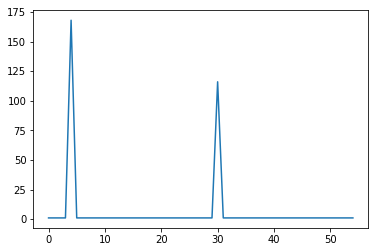

In [13]:
csv = 'p002123.psv'
print(tmp.columns)
tmp = pd.read_csv(
    '/Users/wangkai/Desktop/physionet/data/trainingA/' + csv, sep='|')
plt.plot(list(range(len(tmp))), tmp['Glucose'].fillna(1), label='broadcast')

### 正负样本比例

In [27]:
a_traincsv = listdir('./data/trainingA/')
b_traincsv = listdir('./data/trainingB/')

sick_A = [0, 0]

for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv(
        '/Users/wangkai/Desktop/physionet/data/trainingA/' + csv, sep='|')
    if sum(tmp['SepsisLabel']) > 0:
        sick_A[1] += 1
    else:
        sick_A[0] += 1

sick_B = [0, 0]

for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv(
        '/Users/wangkai/Desktop/physionet/data/trainingB/' + csv, sep='|')
    if sum(tmp['SepsisLabel']) > 0:
        sick_B[1] += 1
    else:
        sick_B[0] += 1

Text(0.5, 1.0, '01 distribution for Sepsis')

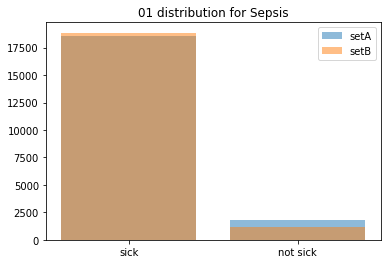

In [28]:
pA = plt.bar(['sick', 'not sick'], sick_A, label='line', alpha=0.5)
pB = plt.bar(['sick', 'not sick'], sick_B, label='line', alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')
plt.title("01 distribution for Sepsis")

### 正样本分析

##### 化验数据比例

In [23]:
a_traincsv = list_a
b_traincsv = list_b

chemdata_A_sick = {}
for i in range(11):
    chemdata_A_sick[i/10] = 0

chem = ['BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
        'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
        'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
        'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
        'Fibrinogen', 'Platelets']


for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('./data/trainingA/' + csv, sep='|')
    tmp_sum = 0
    for c in chem:
        tmp_sum += sum(tmp[c].notna())
    per = int(10 * tmp_sum / (len(chem) * len(tmp))) / 10
    chemdata_A_sick[per] += 1

chemdata_B_sick = {}
for i in range(11):
    chemdata_B_sick[i/10] = 0

for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('./data/trainingB/' + csv, sep='|')
    tmp_sum = 0
    for c in chem:
        tmp_sum += sum(tmp[c].notna())
    per = int(10 * tmp_sum / (len(chem) * len(tmp))) / 10
    chemdata_B_sick[per] += 1

Text(0.5, 1.0, 'laboratory data percentage in single sick person')

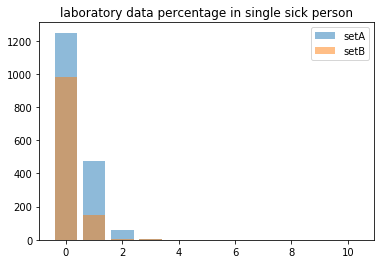

In [26]:
#chemdata_A_sick = pd.DataFrame.from_dict(chemdata_A_sick, orient='index')
#chemdata_B_sick = pd.DataFrame.from_dict(chemdata_B_sick, orient='index')
pA = plt.bar(chemdata_A_sick.index*10,
             chemdata_A_sick[0], label='line', alpha=0.5)
pB = plt.bar(chemdata_B_sick.index*10,
             chemdata_B_sick[0], label='line', alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')

plt.title("laboratory data percentage in single patient")

###### 负样本对比

In [7]:
a_traincsv = list(set(listdir('./data/trainingA/')) - set(list_a))
b_traincsv = list(set(listdir('./data/trainingB/')) - set(list_b))

chemdata_A_normal = {}
for i in range(11):
    chemdata_A_normal[i/10] = 0

chem = ['BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
        'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
        'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
        'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
        'Fibrinogen', 'Platelets']


for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv(
        '/Users/wangkai/Desktop/physionet/data/trainingA/' + csv, sep='|')
    tmp_sum = 0
    for c in chem:
        tmp_sum += sum(tmp[c].notna())
    per = int(10 * tmp_sum / (len(chem) * len(tmp))) / 10
    chemdata_A_normal[per] += 1

chemdata_B_normal = {}
for i in range(11):
    chemdata_B_normal[i/10] = 0

for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv(
        '/Users/wangkai/Desktop/physionet/data/trainingB/' + csv, sep='|')
    tmp_sum = 0
    for c in chem:
        tmp_sum += sum(tmp[c].notna())
    per = int(10 * tmp_sum / (len(chem) * len(tmp))) / 10
    chemdata_B_normal[per] += 1

Text(0.5, 1.0, 'laboratory data percentage in single normal person')

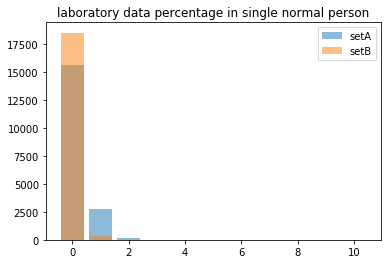

In [8]:
chemdata_A_normal = pd.DataFrame.from_dict(chemdata_A_normal, orient='index')
chemdata_B_normal = pd.DataFrame.from_dict(chemdata_B_normal, orient='index')
pA = plt.bar(chemdata_A_normal.index*10,
             chemdata_A_normal[0], label='line', alpha=0.5)
pB = plt.bar(chemdata_B_normal.index*10,
             chemdata_B_normal[0], label='line', alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')

plt.title("laboratory data percentage in single normal person")

##### 生命体征分析

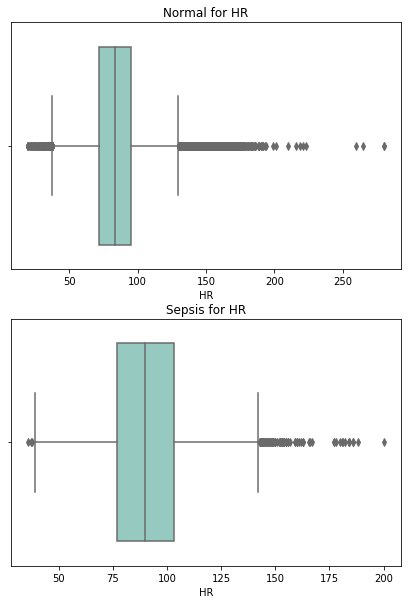

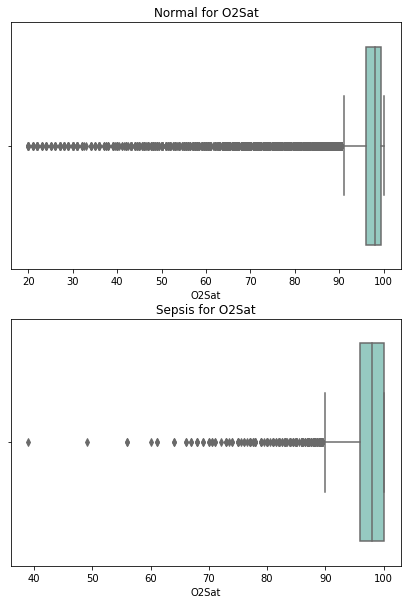

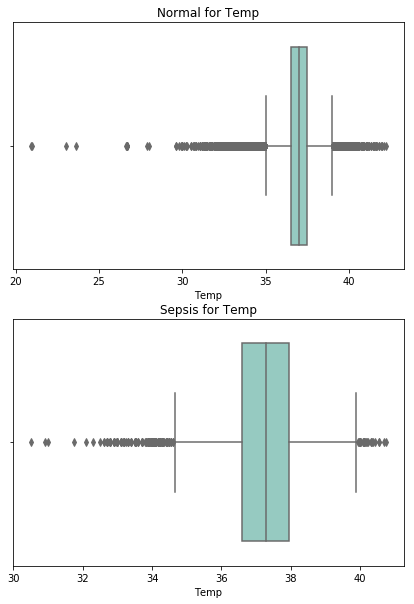

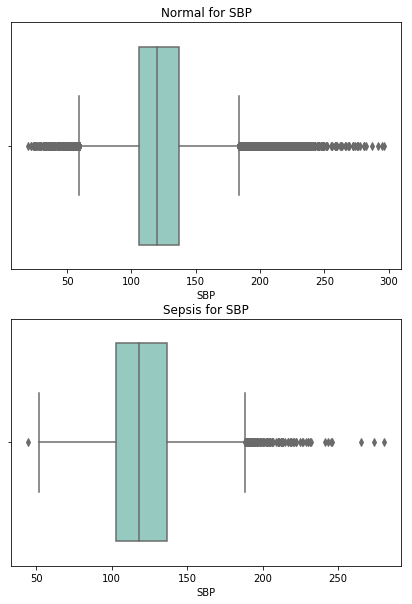

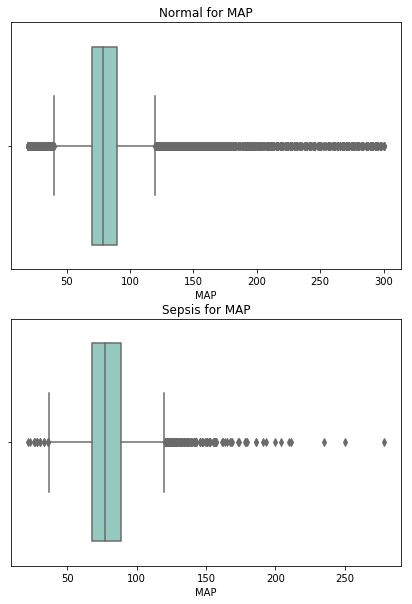

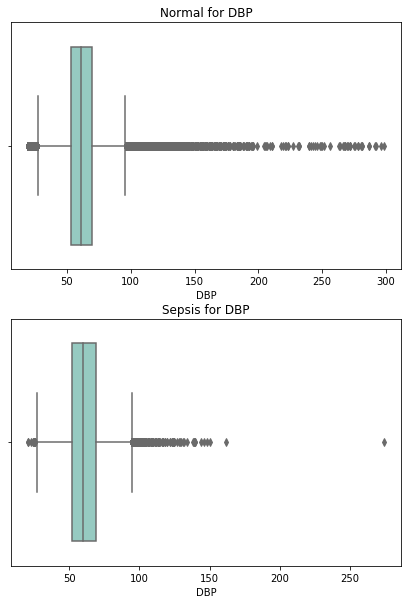

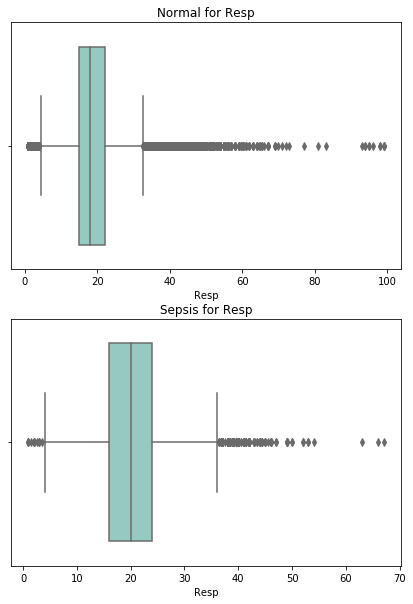

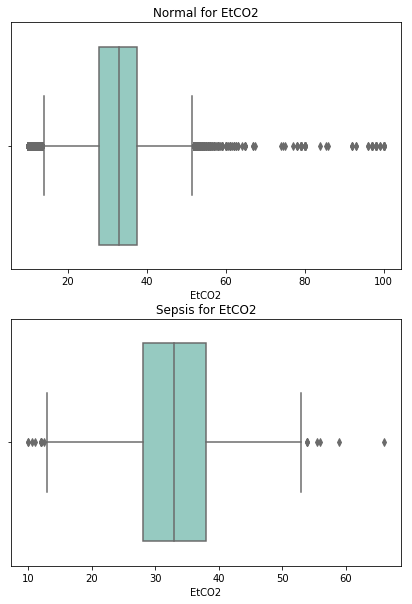

In [26]:
vital_signs = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2']
for i, var in enumerate(vital_signs):
    temp = train[[var, 'SepsisLabel']].dropna()
    temp1 = temp[temp['SepsisLabel'] == 0]
    temp2 = temp[temp['SepsisLabel'] == 1]
    fig, ax = plt.subplots(2, 1, figsize=(7, 10))

    sns.boxplot(temp1[var], ax=ax[0], palette='Set3')
    sns.boxplot(temp2[var], ax=ax[1], palette='Set3')
    ax[0].set_title("Normal for " + var)
    ax[1].set_title("Sepsis for " + var)

### 化验数据分析

##### 化验数据比例

In [7]:
a_traincsv = listdir('./data/trainingA/')
b_traincsv = listdir('./data/trainingB/')

chemdata_A = {}
for i in range(11):
    chemdata_A[i/10] = 0

chem = ['BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
        'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
        'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
        'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
        'Fibrinogen', 'Platelets']


for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('./data/trainingA/' + csv, sep='|')
    tmp_sum = 0
    for c in chem:
        tmp_sum += sum(tmp[c].notna())
    per = int(10 * tmp_sum / (len(chem) * len(tmp))) / 10
    chemdata_A[per] += 1

chemdata_B = {}
for i in range(11):
    chemdata_B[i/10] = 0

for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('./data/trainingB/' + csv, sep='|')
    tmp_sum = 0
    for c in chem:
        tmp_sum += sum(tmp[c].notna())
    per = int(10 * tmp_sum / (len(chem) * len(tmp))) / 10
    chemdata_B[per] += 1

TypeError: unsupported operand type(s) for +: 'int' and 'str'

Text(0.5, 1.0, 'laboratory data percentage in one patient')

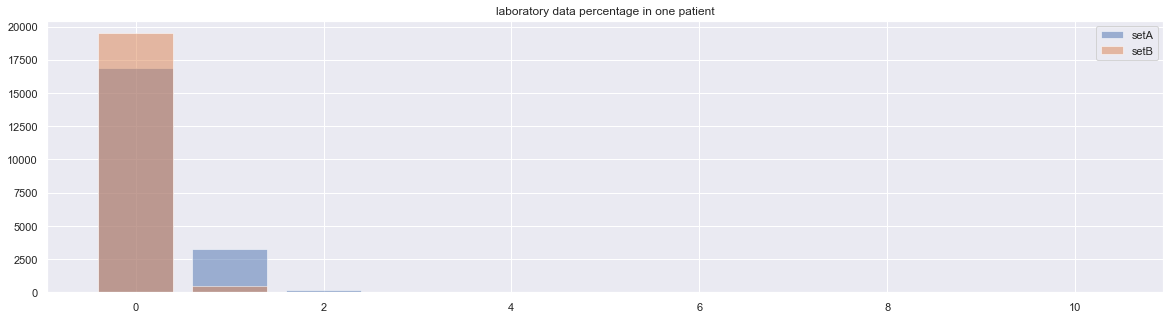

In [299]:
#chemdata_A = pd.DataFrame.from_dict(chemdata_A, orient='index')
#chemdata_B = pd.DataFrame.from_dict(chemdata_B, orient='index')
pA = plt.bar(chemdata_A.index*10, chemdata_A[0], label='line', alpha=0.5)
pB = plt.bar(chemdata_B.index*10, chemdata_B[0], label='line', alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')

plt.title("laboratory data percentage in one patient")

### 单病人观察时间长度分布

In [122]:
a_traincsv = patient_a
b_traincsv = patient_b

distributionA = {}
for i in range(500):
    distributionA[i] = 0
for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('./data/trainingA/' + csv)
    distributionA[len(tmp)] += 1

distributionB = {}
for i in range(500):
    distributionB[i] = 0
for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('./data/trainingB/' + csv)
    distributionB[len(tmp)] += 1

Text(0.5, 1.0, 'length distribution of patient set ')

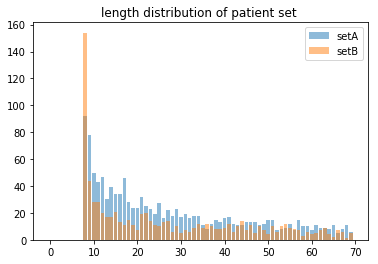

In [126]:
length_A = pd.DataFrame.from_dict(distributionA, orient='index')
length_B = pd.DataFrame.from_dict(distributionB, orient='index')
pA = plt.bar(length_A.index[:70], length_A[0][:70], label='line', alpha=0.5)
pB = plt.bar(length_B.index[:70], length_B[0][:70], label='line', alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')
plt.title("length distribution of patient set ")

### 病人平均发病时间

In [18]:
a_traincsv = listdir('./data/trainingA/')
b_traincsv = listdir('./data/trainingB/')

distributionA = {}
for i in range(500):
    distributionA[i] = 0
for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('./data/trainingA/' + csv, sep='|')
    if int(tmp['SepsisLabel'].tail(1)) == 1:
        distributionA[len(tmp[tmp['SepsisLabel'] == 0])] += 1

distributionB = {}
for i in range(500):
    distributionB[i] = 0
for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('./data/trainingB/' + csv, sep='|')
    if int(tmp['SepsisLabel'].tail(1)) == 1:
        distributionB[len(tmp[tmp['SepsisLabel'] == 0])] += 1


/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


Text(0.5, 1.0, 'Time befored judged as sepsis ')

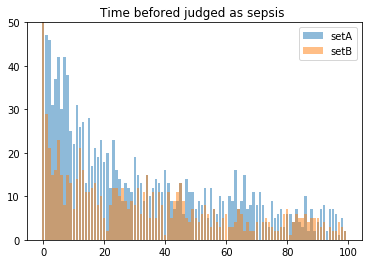

In [24]:
length_A = pd.DataFrame.from_dict(distributionA, orient='index')
length_B = pd.DataFrame.from_dict(distributionB, orient='index')
pA = plt.bar(length_A.index[:100], length_A[0][:100], label='line', alpha=0.5)
pB = plt.bar(length_B.index[:100], length_B[0][:100], label='line', alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')
plt.ylim(ymax=50)
plt.title("Time befored judged as sepsis ")

### 单病人被判断患病的时间段占比

In [102]:
a_traincsv = listdir('./data/trainingA/')
b_traincsv = listdir('./data/trainingB/')

one_percentage_A = {}
for i in range(11):
    one_percentage_A[i/10] = 0
for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('./data/trainingA/' + csv, sep='|')
    percentage = int(10 * sum(tmp['SepsisLabel']) / len(tmp))/10
    one_percentage_A[percentage] += 1

one_percentage_B = {}
for i in range(11):
    one_percentage_B[i/10] = 0
for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('./data/trainingB/' + csv, sep='|')
    percentage = int(10 * sum(tmp['SepsisLabel']) / len(tmp))/10
    one_percentage_B[percentage] += 1

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


Text(0.5, 1.0, "1 label percentage in total 'SepsisLabel' for patients(10 means 100%)")

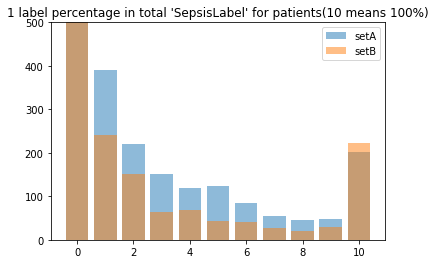

In [176]:
percentage_A = pd.DataFrame.from_dict(one_percentage_A, orient='index')
percentage_B = pd.DataFrame.from_dict(one_percentage_B, orient='index')
pA = plt.bar(percentage_A.index*10, percentage_A[0], label='line', alpha=0.5)
pB = plt.bar(percentage_B.index*10, percentage_B[0], label='line', alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')

plt.ylim(ymax=500)
plt.title("1 label percentage in total 'SepsisLabel' for patients(10 means 100%)")

### ICU种类分布

In [204]:
unit1 = 0
unit2 = 0
unit3 = 0
for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('./data/trainingA/' + csv, sep='|')
    if sum(tmp['Unit1'].fillna(0)) == len(tmp):
        unit1 += 1
    elif sum(tmp['Unit2'].fillna(0)) == len(tmp):
        unit2 += 1
    else:
        unit3 += 1

unit4 = 0
unit5 = 0
unit6 = 0
for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('./data/trainingB/' + csv, sep='|')
    if sum(tmp['Unit1'].fillna(0)) == len(tmp):
        unit4 += 1
    elif sum(tmp['Unit2'].fillna(0)) == len(tmp):
        unit5 += 1
    else:
        unit6 += 1

Text(0.5, 1.0, 'ICU kind distribution')

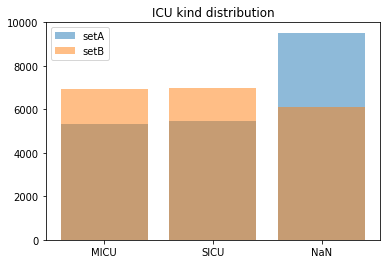

In [213]:
pA = plt.bar(['MICU', 'SICU', 'NaN'], [unit1, unit2, unit3], alpha=0.5)
pB = plt.bar(['MICU', 'SICU', 'NaN'], [unit4, unit5, unit6], alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')

plt.title('ICU kind distribution')

### 性别分析

In [217]:
sex = [0 for _ in range(6)]
for i, csv in enumerate(a_traincsv):
    tmp = pd.read_csv('./data/trainingA/' + csv, sep='|')
    if sum(tmp['Gender'].fillna(-1)) == 0:
        sex[0] += 1
    elif sum(tmp['Gender'].fillna(-1)) == len(tmp):
        sex[1] += 1
    else:
        sex[2] += 1

for i, csv in enumerate(b_traincsv):
    tmp = pd.read_csv('./data/trainingB/' + csv, sep='|')
    if sum(tmp['Gender'].fillna(-1)) == 0:
        sex[3] += 1
    elif sum(tmp['Gender'].fillna(-1)) == len(tmp):
        sex[4] += 1
    else:
        sex[5] += 1

Text(0.5, 1.0, 'sex distribution')

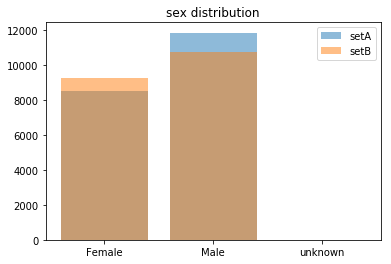

In [218]:
pA = plt.bar(['Female', 'Male', 'unknown'], sex[:3], alpha=0.5)
pB = plt.bar(['Female', 'Male', 'unknown'], sex[3:], alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')
plt.title('sex distribution')

### 年龄分析

In [8]:
a_traincsv = listdir('./data/trainingA/')
b_traincsv = listdir('./data/trainingB/')

age_A = {}
for i in range(120):
    age_A[i] = 0
for i, csv in enumerate(tqdm(a_traincsv)):
    tmp = pd.read_csv('./data/trainingA/' + csv, sep='|')
    age = int(tmp['Age'][2])
    age_A[age] += 1

age_B = {}
for i in range(120):
    age_B[i] = 0
for i, csv in enumerate(tqdm(b_traincsv)):
    tmp = pd.read_csv('./data/trainingB/' + csv, sep='|')
    age = int(tmp['Age'][2])
    age_B[age] += 1

100%|██████████| 20000/20000 [01:04<00:00, 311.63it/s]


/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


Text(0.5, 1.0, 'age distribution')

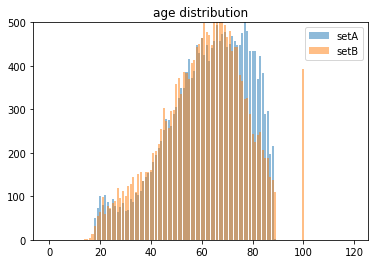

In [9]:
age_A = pd.DataFrame.from_dict(age_A, orient='index')
age_B = pd.DataFrame.from_dict(age_B, orient='index')
pA = plt.bar(age_A.index, age_A[0], label='line', alpha=0.5)
pB = plt.bar(age_B.index, age_B[0], label='line', alpha=0.5)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')

plt.ylim(ymax=500)
plt.title("age distribution")

B中最小的是14岁 A中最小的是18岁 B中有400多个100岁的

### 缺失度分析

In [239]:
train = pd.read_csv('./train.psv', sep='|')
train.shape

(1170446, 41)

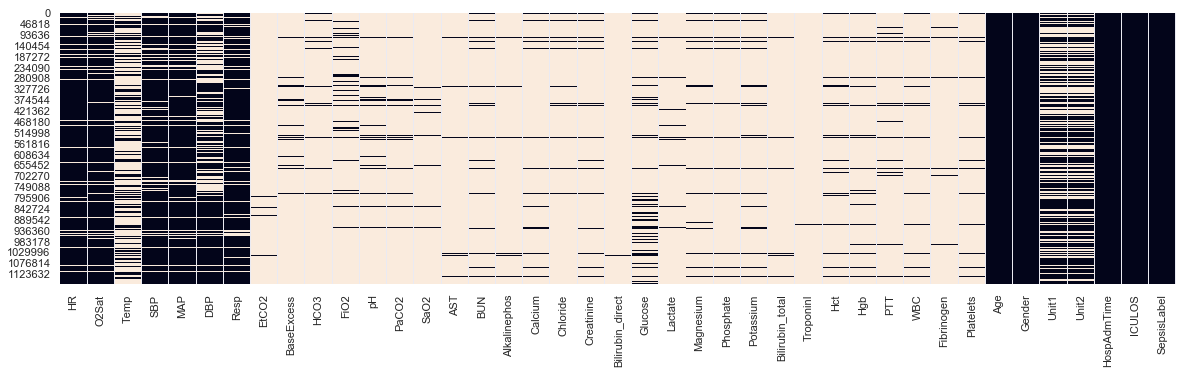

In [244]:
sns.set(rc={'figure.figsize': (20, 5)})
sns.heatmap(train.isnull(), cbar=False)

### 某检查与发病的关系

In [65]:
lab_values = ['BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets']

In [110]:
a_traincsv = patient_a
b_traincsv = patient_b

distributionA = {}
for lab in lab_values:
    distributionA[lab] = []
for i, csv in enumerate(tqdm(a_traincsv)):
    tmp = pd.read_csv('./data/trainingA/' + csv, sep='|')
    gap = len(tmp[tmp['SepsisLabel'] == 0]) - 1
    for lab in lab_values:
        l = -1
        tmp[lab] = tmp[lab].fillna(-1)
        for index in range(1, len(tmp[lab])):
            
            if list(tmp[lab])[index] != -1 and list(tmp['SepsisLabel'])[index - 1] == 0:
                l = index
            if list(tmp['SepsisLabel'])[index - 1] == 0 and list(tmp['SepsisLabel'])[index] == 1:
                gap = max(-1, gap - l + 1)
                distributionA[lab].append(gap)
            
        

distributionB = {}
for lab in lab_values:
    distributionB[lab] = []
for i, csv in enumerate(tqdm(b_traincsv)):
    tmp = pd.read_csv('./data/trainingB/' + csv, sep='|')
    gap = len(tmp[tmp['SepsisLabel'] == 0]) - 1
    for lab in lab_values:
        l = -1
        tmp[lab] = tmp[lab].fillna(-1)
        for index in range(1, len(tmp[lab])):
            
            if list(tmp[lab])[index] != -1 and list(tmp['SepsisLabel'])[index - 1] == 0:
                l = index
            if list(tmp['SepsisLabel'])[index - 1] == 0 and list(tmp['SepsisLabel'])[index] == 1:
                gap = max(-1, gap - l + 1)
                distributionB[lab].append(gap)
            
        








  0%|          | 0/1790 [00:00<?, ?it/s]




  0%|          | 1/1790 [00:00<15:26,  1.93it/s]




  0%|          | 4/1790 [00:00<11:32,  2.58it/s]




  0%|          | 8/1790 [00:00<08:26,  3.52it/s]




  1%|          | 13/1790 [00:01<06:07,  4.84it/s]




  1%|          | 15/1790 [00:01<05:15,  5.63it/s]




  1%|          | 17/1790 [00:01<04:13,  7.00it/s]




  1%|          | 19/1790 [00:01<03:52,  7.61it/s]




  1%|          | 21/1790 [00:01<03:44,  7.88it/s]




  1%|▏         | 26/1790 [00:02<02:55, 10.06it/s]




  2%|▏         | 28/1790 [00:02<02:54, 10.10it/s]




  2%|▏         | 30/1790 [00:02<03:07,  9.41it/s]




  2%|▏         | 32/1790 [00:02<02:53, 10.11it/s]




  2%|▏         | 34/1790 [00:02<03:04,  9.52it/s]




  2%|▏         | 37/1790 [00:03<03:00,  9.73it/s]




  2%|▏         | 39/1790 [00:03<02:38, 11.06it/s]




  2%|▏         | 41/1790 [00:03<03:35,  8.13it/s]




  2%|▏         | 44/1790 [00:03<03:04,  9.47it/s]




  3%|▎         | 47/1790 [00:04<03:

 35%|███▍      | 620/1790 [00:53<01:43, 11.34it/s]




 35%|███▍      | 625/1790 [00:53<01:19, 14.63it/s]




 35%|███▌      | 628/1790 [00:53<01:37, 11.96it/s]




 35%|███▌      | 630/1790 [00:54<01:31, 12.73it/s]




 35%|███▌      | 632/1790 [00:54<02:16,  8.50it/s]




 35%|███▌      | 634/1790 [00:54<02:26,  7.90it/s]




 36%|███▌      | 636/1790 [00:55<03:18,  5.81it/s]




 36%|███▌      | 637/1790 [00:55<03:13,  5.97it/s]




 36%|███▌      | 638/1790 [00:55<03:02,  6.30it/s]




 36%|███▌      | 639/1790 [00:55<03:29,  5.49it/s]




 36%|███▌      | 640/1790 [00:56<03:27,  5.55it/s]




 36%|███▌      | 642/1790 [00:56<03:00,  6.37it/s]




 36%|███▌      | 643/1790 [00:56<03:27,  5.53it/s]




 36%|███▌      | 646/1790 [00:56<03:14,  5.89it/s]




 36%|███▌      | 648/1790 [00:57<02:41,  7.06it/s]




 36%|███▋      | 650/1790 [00:57<02:12,  8.62it/s]




 36%|███▋      | 652/1790 [00:57<02:02,  9.32it/s]




 37%|███▋      | 654/1790 [00:57<01:59,  9.51it/s]




 37%|███▋ 

 68%|██████▊   | 1221/1790 [01:44<00:55, 10.24it/s]




 68%|██████▊   | 1223/1790 [01:44<01:00,  9.33it/s]




 69%|██████▊   | 1227/1790 [01:44<00:49, 11.44it/s]




 69%|██████▊   | 1230/1790 [01:44<00:40, 13.85it/s]




 69%|██████▉   | 1232/1790 [01:44<00:38, 14.49it/s]




 69%|██████▉   | 1234/1790 [01:45<00:37, 14.77it/s]




 69%|██████▉   | 1236/1790 [01:45<00:35, 15.74it/s]




 69%|██████▉   | 1238/1790 [01:45<00:37, 14.84it/s]




 69%|██████▉   | 1240/1790 [01:45<00:43, 12.76it/s]




 69%|██████▉   | 1242/1790 [01:45<00:38, 14.20it/s]




 69%|██████▉   | 1244/1790 [01:45<00:37, 14.59it/s]




 70%|██████▉   | 1246/1790 [01:46<00:55,  9.74it/s]




 70%|██████▉   | 1249/1790 [01:46<00:46, 11.68it/s]




 70%|██████▉   | 1251/1790 [01:46<00:41, 12.87it/s]




 70%|███████   | 1253/1790 [01:46<00:38, 13.90it/s]




 70%|███████   | 1256/1790 [01:46<00:44, 12.06it/s]




 70%|███████   | 1259/1790 [01:47<00:42, 12.56it/s]




 71%|███████   | 1262/1790 [01:47<00:35, 14.74it

  0%|          | 2/1142 [00:00<04:35,  4.14it/s]




  0%|          | 4/1142 [00:00<03:39,  5.17it/s]




  1%|          | 6/1142 [00:00<03:00,  6.29it/s]




  1%|          | 9/1142 [00:01<02:20,  8.07it/s]




  1%|          | 12/1142 [00:01<01:54,  9.91it/s]




  1%|          | 14/1142 [00:01<01:51, 10.16it/s]




  1%|▏         | 16/1142 [00:01<02:25,  7.74it/s]




  2%|▏         | 18/1142 [00:01<02:10,  8.60it/s]




  2%|▏         | 20/1142 [00:02<02:17,  8.15it/s]




  2%|▏         | 22/1142 [00:02<02:42,  6.90it/s]




  2%|▏         | 23/1142 [00:02<02:46,  6.71it/s]




  2%|▏         | 24/1142 [00:02<02:42,  6.89it/s]




  2%|▏         | 27/1142 [00:03<02:54,  6.38it/s]




  3%|▎         | 29/1142 [00:03<02:31,  7.34it/s]




  3%|▎         | 33/1142 [00:03<01:56,  9.52it/s]




  3%|▎         | 36/1142 [00:04<01:47, 10.32it/s]




  3%|▎         | 38/1142 [00:04<01:36, 11.45it/s]




  4%|▎         | 40/1142 [00:04<01:26, 12.81it/s]




  4%|▎         | 42/1142 [00:04<

 53%|█████▎    | 610/1142 [00:55<00:51, 10.24it/s]




 54%|█████▎    | 612/1142 [00:55<00:50, 10.42it/s]




 54%|█████▍    | 615/1142 [00:55<00:44, 11.96it/s]




 54%|█████▍    | 617/1142 [00:55<00:53,  9.87it/s]




 54%|█████▍    | 620/1142 [00:56<01:05,  7.98it/s]




 54%|█████▍    | 622/1142 [00:56<00:59,  8.76it/s]




 55%|█████▍    | 625/1142 [00:56<00:50, 10.31it/s]




 55%|█████▍    | 628/1142 [00:56<00:40, 12.77it/s]




 55%|█████▌    | 630/1142 [00:57<01:07,  7.54it/s]




 55%|█████▌    | 633/1142 [00:58<01:30,  5.62it/s]




 56%|█████▌    | 636/1142 [00:58<01:27,  5.77it/s]




 56%|█████▌    | 639/1142 [00:58<01:06,  7.61it/s]




 56%|█████▌    | 641/1142 [00:59<01:03,  7.92it/s]




 56%|█████▋    | 644/1142 [00:59<01:22,  6.06it/s]




 57%|█████▋    | 646/1142 [01:00<01:12,  6.83it/s]




 57%|█████▋    | 648/1142 [01:00<00:59,  8.24it/s]




 57%|█████▋    | 650/1142 [01:00<01:04,  7.66it/s]




 57%|█████▋    | 652/1142 [01:00<00:53,  9.24it/s]




 57%|█████

In [111]:
distributionA_ = {}
distributionB_ = {}
for feature in distributionA:
    d = distributionA[feature]
    while -1 in d:
        d.remove(-1)
    distributionA_[feature] = sum(d)/len(d) if len(d) != 0 else 0
for feature in distributionB:
    d = distributionB[feature]
    while -1 in d:
        d.remove(-1)
    distributionB_[feature] = sum(d)/len(d) if len(d) != 0 else 0

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')


([<matplotlib.axis.XTick at 0x1a28103cc0>,
 <a list of 26 Text xticklabel objects>)

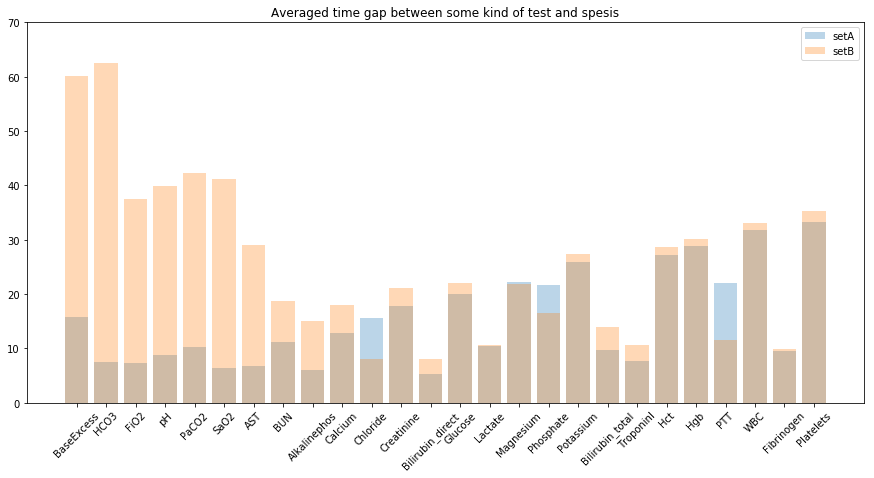

In [114]:
plt.figure(figsize=(15, 7))
length_A = pd.DataFrame.from_dict(distributionA_, orient='index')
length_B = pd.DataFrame.from_dict(distributionB_, orient='index')
pA = plt.bar(length_A.index[:100], length_A[0][:100], label='line', alpha=0.3)
pB = plt.bar(length_B.index[:100], length_B[0][:100], label='line', alpha=0.3)
plt.legend(handles=[pA, pB], labels=['setA', 'setB'], loc='best')
plt.ylim(ymax=70)
plt.title("Averaged time gap between some kind of test and spesis")
plt.xticks(list(range(len(list(distributionA.keys())))), list(distributionA.keys()), rotation=45, fontsize=10)

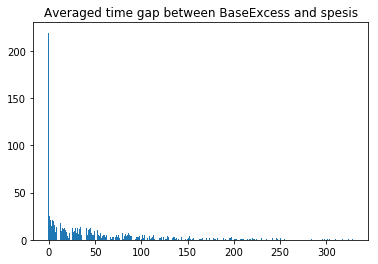

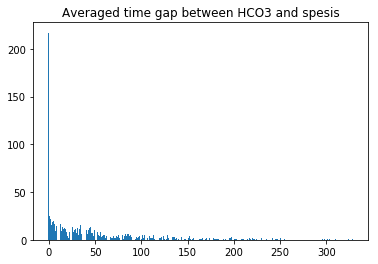

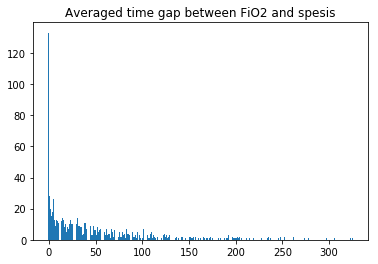

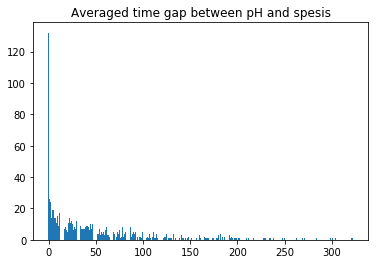

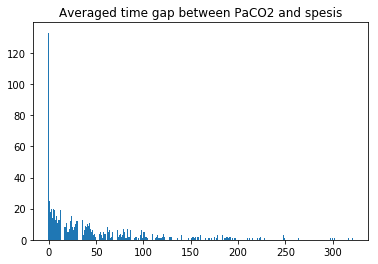

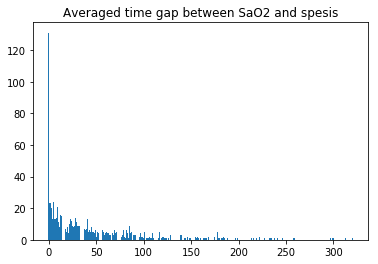

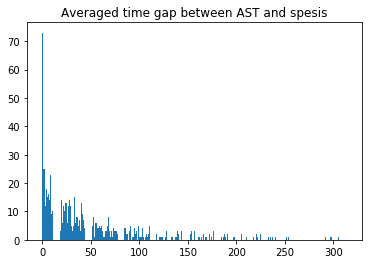

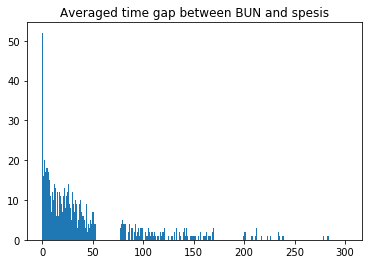

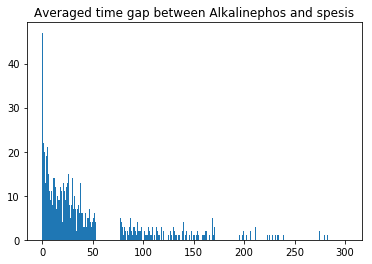

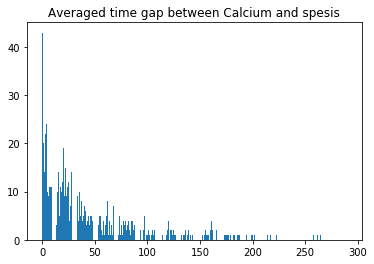

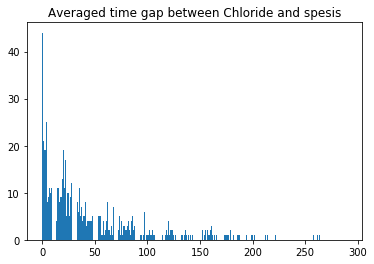

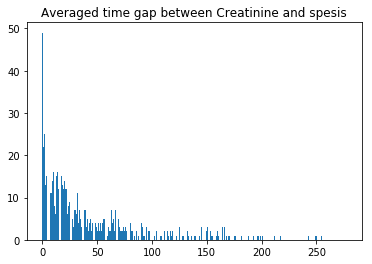

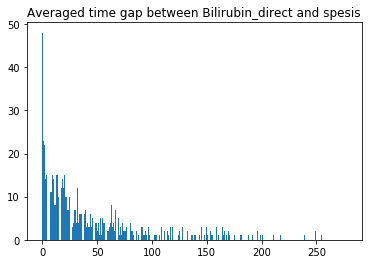

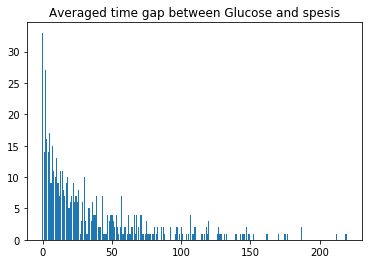

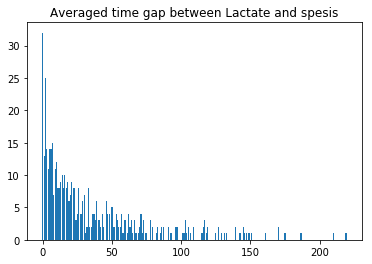

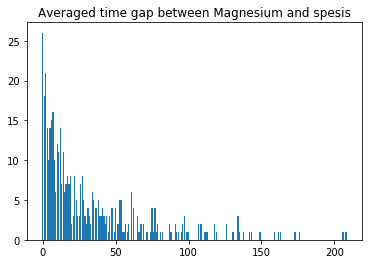

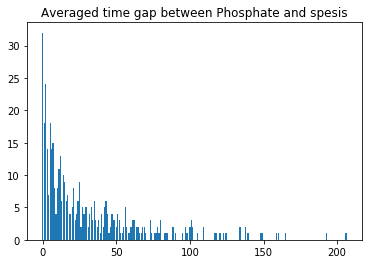

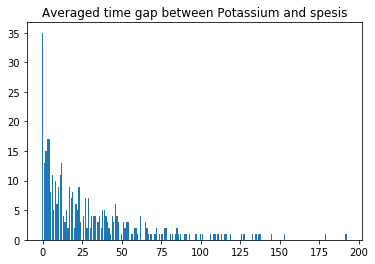

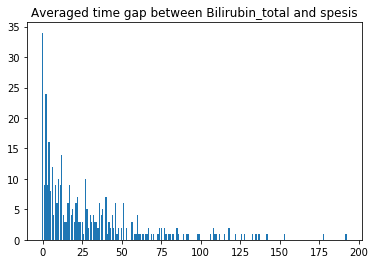

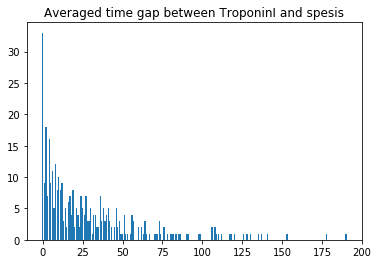

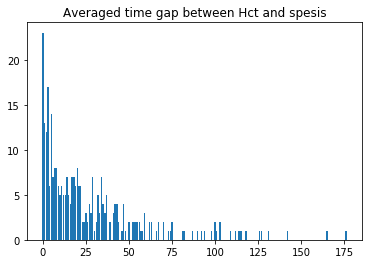

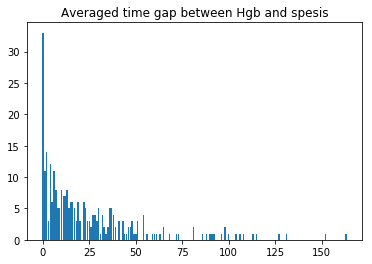

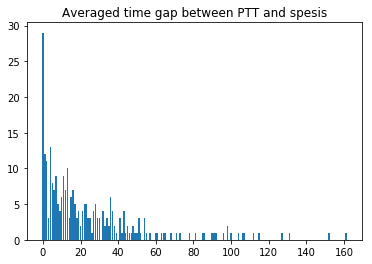

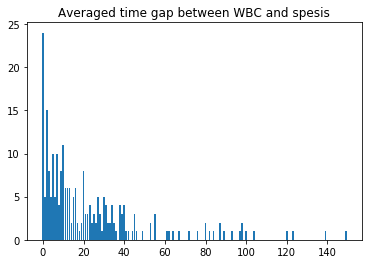

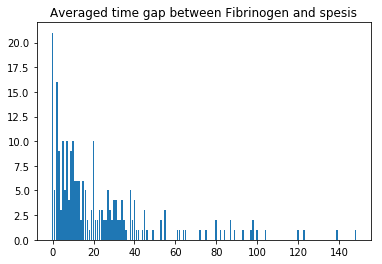

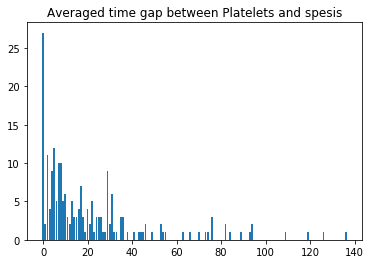

In [52]:
for i in range(len(lab_values)):
    plt.figure(i)
    plt.bar(list(Counter(distributionB[lab_values[i]])),(Counter(distributionB[lab_values[i]])).values())
    plt.title(f'Averaged time gap between {lab_values[i]} and spesis')
      

# Data processing

In [16]:
train = pd.read_csv('./data/train.psv', sep='|')
len(train)

1552265

decoration

In [29]:
def mission_complete(func):
    def wrapper(train):
        print(f'{func} is running')
        return func(train)
    return wrapper


## Kill the NaN

去掉每一个psv中的NaN 

In [27]:
feature_org = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets']

In [28]:
a_traincsv = listdir('./data/trainingA/')
for i,csv in tqdm(enumerate(a_traincsv)):
    with open(f"./data/processedA/trainA_{i}.pkl", 'wb') as file:
        cur_train = pd.read_csv(f'./data/trainingA/' + csv, sep='|')
        cur_train = cur_train.fillna(method='pad')
        pickle.dump(cur_train, file)
        
b_traincsv = listdir('./data/trainingB/')
for i,csv in tqdm(enumerate(b_traincsv)):
    with open(f"./data/processedB/trainB_{i}.pkl", 'wb') as file:
        cur_train = pd.read_csv(f'./data/trainingB/' + csv, sep='|')
        cur_train = cur_train.fillna(method='pad')
        pickle.dump(cur_train, file)

1453it [00:07, 192.84it/s]


KeyboardInterrupt: 

将ABset分别存成一个大pkl文件

In [ ]:
a_pkl = listdir('./data/processedA/')
b_pkl = listdir('./data/processedB/')

trainA = [[] for _ in range(42)]
trainB = [[] for _ in range(42)]

for i in range(40):
    print(f'set****************************{i}******************************')
    with open(f'./data/processedA/trainA_{i * 500}.pkl', 'rb') as file:
        trainA[i] = pickle.load(file)
    with open(f'./data/processedB/trainB_{i * 500}.pkl', 'rb') as file:
        trainB[i] = pickle.load(file)
        
    for _, pkl in enumerate(tqdm(a_pkl[i * 500 + 1:(i + 1) * 500 + 1])):
        if pkl == '.DS_Store':
            continue
        with open(f'./data/processedA/' + pkl, 'rb') as file:
            tmp = pickle.load(file)
            trainA[i] = pd.merge(trainA[i], tmp,how='outer')
    
#     for _, pkl in enumerate(tqdm(b_pkl[i * 500 + 1:(i + 1) * 500 + 1])):
#         with open(f'./data/processedB/' + pkl, 'rb') as file:
#             tmp = pickle.load(file)
#             trainB[i] = pd.merge(trainB[i], tmp,how='outer')

            
with open(f'./data/processedA/trainA_{20001}.pkl', 'rb') as file:
    trainA[40] = pickle.load(file)

for _, pkl in tqdm(enumerate(a_pkl[40 * 500 + 2:])):
    with open(f'./data/processedA/' + pkl, 'rb') as file:
        tmp = pickle.load(file)
        trainA[40] = pd.merge(trainA[40], tmp,how='outer')
    


In [41]:
trainA[41] = trainA[0]
with open(f"./data/processedA/trainA.pkl", 'wb') as file_A:
    for i in range(41):
        tmp = trainA[i]
        trainA[41] = pd.merge(trainA[41], tmp,how='outer')
    pickle.dump(trainA[41], file_A)


In [ ]:
trainB[41] = trainB[0]
with open(f"./data/processedB/trainB.pkl", 'wb') as file_B:
    for i in range(1,40):
        tmp = trainB[i]
        trainB[41] = pd.merge(trainB[41], tmp,how='outer')
    pickle.dump(trainB[41], file_B)

## Feature Engineering

### Vital Signs

#### Heart Rate (beats per minute)

Heart rate for a healthy adult is between 60 and 100. For a healthy infant it is between 70 and 190. 

In [77]:
@mission_complete
def feature_engineer_hr(train):
    train.loc[(train['HR'] >= 100) & (train['Age'] >= 10 ),'custom_hr'] = 'abnormal'
    train.loc[(train['HR'] < 100) & (train['HR'] > 60) & (train['Age'] >= 10 ),'custom_hr'] = 'normal'
    train.loc[(train['HR'] >= 70) & (train['HR'] < 190) & (train['Age'] < 10 ),'custom_hr'] = 'normal'
    train.loc[((train['HR'] < 70) | (train['HR'] >= 190)) & (train['Age'] < 10 ),'custom_hr'] = 'abnormal'
    train['custom_hr'] = train['custom_hr'].fillna('Missing')
    return train

#### Temperature (Deg C)

Temperature for a healthy human being is between 36.4 degree C to 37.6 degree C. 

In [78]:
@mission_complete
def feature_engineer_temp(train):
    train.loc[(train['Temp'] >= 36.4) & (train['Temp'] < 37.6), 'custom_temp'] = 'normal'
    train.loc[(train['Temp'] < 36.4) | (train['Temp'] >= 37.6), 'custom_temp'] = 'abnormal'
    train['custom_temp'] = train['custom_temp'].fillna('Missing')
    return train


#### Age

Categorizing patient based on age to old, infant and adult

In [79]:
@mission_complete
def feature_engineer_age(train):
    train.loc[train['Age'] >=65, 'custom_age'] = 'old'
    train.loc[train['Age'] <10, 'custom_age'] = 'infant'
    train.loc[(train['Age'] >=10) & (train['Age'] <65), 'custom_age'] = 'adult'
    return train

#### O2Stat (%)

O2Stat for a healthy adult is between 90 and 100 for healthy human beings. Create a new categorical variable custom_o2stat with levels normal, abnormal and missing

In [80]:
@mission_complete
def feature_engineer_o2sat(train):
    train.loc[(train['O2Sat'] >= 90) & (train['O2Sat'] < 100), 'custom_o2sat'] = 'normal'
    train.loc[(train['O2Sat'] < 90) & (train['O2Sat'] >= 0), 'custom_o2sat'] = 'abnormal'
    train['custom_o2sat'] = train['custom_o2sat'].fillna('Missing')
    return train


#### SBP DBP (mm Hg)

SBP stands for Systolic blood pressure, It is the upper number while measuring Blood pressure.
DBP stands for Diastolic blood pressure , It is the lower number while measuring Blood pressure.
Using both these columns to categorize blood pressure as low, normal, elevated , high and missing

In [81]:
@mission_complete
def feature_engineer_blood_pressure(train):
    train.loc[(train['SBP'] <90) & (train['DBP'] <60), 'custom_bp'] = 'low'
    train.loc[(train['SBP'].between(90,120, inclusive=True)) & (train['DBP'].between(60,80, inclusive=True)), 'custom_bp'] = 'normal'
    train.loc[(train['SBP'].between(120,140, inclusive=True)) & (train['DBP'].between(80,90, inclusive=True)), 'custom_bp'] = 'elevated'
    train.loc[(train['SBP'] > 140 ) & (train['DBP'] > 90 ), 'custom_bp'] = 'high'
    train['custom_bp'] = train['custom_bp'].fillna('Missing')
    return train

#### Respiration Rate (breath per minute)

Respiration rate for healthy adults is between 12 and 20. 

In [82]:
@mission_complete
def feature_engineer_resp_rate(train):
    train.loc[(train['Resp'].between(30,60)) & (train['Age'] <1), 'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 30) | (train['Resp'] > 60)) & (train['Age'] <1) ,'custom_resp'] = 'abnormal'
    train.loc[(train['Resp'].between(24,40)) & (train['Age'].between(1,3)), 'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 24) | (train['Resp'] > 40)) & (train['Age'].between(1,3)) ,'custom_resp'] = 'abnormal'
    train.loc[(train['Resp'].between(22,34)) & (train['Age'].between(3,6)), 'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 22) | (train['Resp'] > 34)) & (train['Age'].between(3,6)) ,'custom_resp'] = 'abnormal'
    train.loc[(train['Resp'].between(18,30)) & (train['Age'].between(6,12)), 'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 18) | (train['Resp'] > 30)) & (train['Age'].between(6,12)) ,'custom_resp'] = 'abnormal'
    train.loc[(train['Resp'].between(12,20)) & (train['Age'] >12), 'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 12) | (train['Resp'] > 20)) & (train['Age'] >12),'custom_resp'] = 'abnormal'
    train['custom_resp'] = train['custom_resp'].fillna('Missing')
    return train
  

#### EtCO2 (mm Hg)

Summary. End-tidal CO2 (EtCO2) monitoring is a noninvasive technique which measures the partial pressure or maximal concentration of carbon dioxide (CO2) at the end of an exhaled breath, which is expressed as a percentage of CO2 or mmHg. The normal values are 5% to 6% CO2, which is equivalent to 35-45 mmHg. 

In [83]:
@mission_complete
def feature_engineer_etco2(train):
    train.loc[(train['EtCO2'] >= 35) & (train['EtCO2'] <=45), 'custom_etco2'] = 'normal'
    train.loc[(train['EtCO2'] < 35) | (train['EtCO2'] > 45), 'custom_etco2'] = 'abnormal'
    train['custom_etco2'] = train['custom_etco2'].fillna('Missing')
    return train


### Laboratory values

#### BaseExcess (mmol/L)

Base excess. Medical diagnostics. LOINC. 11555-0. In physiology, base excess and base deficit refer to an excess or deficit, respectively, in the amount of base present in the blood. -3 to 3 is normal range.

In [115]:
@mission_complete
def feature_engineer_baseexcess(train):
    feature = 'BaseExcess'
    train.loc[(train['BaseExcess'] >= -3) & (train['BaseExcess'] <= 3), 'custom_be'] = 'normal'
    train.loc[(train['BaseExcess'] < -3) | (train['BaseExcess'] > 3), 'custom_be'] = 'abnormal'
    train['custom_be'] = train['custom_be'].fillna('Missing')
    return train


#### HCO3 (mmol/L)

实际碳酸氢盐,在隔绝空气的血液标本在实验室条件下所测得的血浆碳酸氢盐值。正常情况下为22-27mmol/L,平均值为24mmol/L,动静脉血大致相等

In [116]:
@mission_complete
def feature_engineer_hco3(train):
    feature = 'HCO3'
    train.loc[(train[feature] >= 22) & (train[feature] <= 27), 'custom_hco3'] = 'normal'
    train.loc[(train[feature] < 22) | (train[feature] > 27), 'custom_hco3'] = 'abnormal'
    train['custom_hco3'] = train['custom_hco3'].fillna('Missing')
    return train


#### FiO2 & SaO2 (%)

Partial pressure of oxygen (PaO2): 75 to 100 millimeters of mercury (mm Hg), or 10.5 to 13.5 kilopascal (kPa) 

SaO2: Normal arterial oxygen is approximately 75 to 100 millimeters of mercury (mm Hg). Values under 60 mm Hg usually indicate the need for supplemental oxygen. Normal pulse oximeter readings usually range from 95 to 100 percent. Values under 90 percent are considered low

FiO2: Normal range (PaO2/FiO2): = 400

In [117]:
@mission_complete
def feature_engineer_fso2(train):
    feature = 'FiO2'
    feature_ = 'SaO2'
    custom = 'custom_fio2'
    custom_ = 'custom_sao2'
    
    train.loc[(train[feature] >= 0.18) & (train[feature] <= 0.25), custom] = 'normal'
    train.loc[(train[feature] < 0.18) | (train[feature] > 0.25), custom] = 'abnormal'
    
    train.loc[(train[feature_] >= 94) & (train[feature_] <= 100), custom_] = 'normal'
    train.loc[(train[feature_] < 94) | (train[feature_] > 100), custom_] = 'abnormal'
    
    train[custom] = train[custom].fillna('Missing')
    train[custom_] = train[custom_].fillna('Missing')
    return train


#### PaCO2 (mm Hg)

Partial pressure of carbon dioxide (PaCO2): 38 to 42 mm Hg (5.1 to 5.6 kPa) Arterial blood pH: 7.38 to 7.42. 

Like most medical normal values and ranges, the definition can vary slightly, but generally the following definitions apply: Mild hypoxemia: PaO2 = 60 to 79 mmHg. Moderate hypoxemia: PaO2 = 40 to 59 mmHg. Severe hypoxemia: PaO2 < 40 mmHg.

In [140]:
@mission_complete
def feature_engineer_paco2(train):
    feature = 'PaCO2'
    custom = 'custom_paco2'
    train.loc[(train[feature] >= 38) & (train[feature] <= 42), 'custom_paco2'] = 'normal'
    train.loc[(train[feature].between(42, 59)), 'custom_paco2'] = 'moderate'
    train.loc[(train[feature] >= 60), 'custom_paco2'] = 'serious'
    train.loc[(train[feature] < 38), 'custom_paco2'] = 'low'

    train[custom] = train[custom].fillna('Missing')
    return train


#### pH

血液酸碱度即血液内氢离子浓度的负对数值，一般以pH值作为指标，正常人血液的酸碱度保持相对恒定，变动范围在7.35～7.45之间。

In [141]:
@mission_complete
def feature_engineer_ph(train):
    feature = 'pH'
    custom = 'custom_ph'
    train.loc[(train[feature] >= 7.35) & (train[feature] <= 7.45), 'custom_ph'] = 'normal'
    train.loc[(train[feature] < 7.35) | (train[feature] > 7.45), 'custom_ph'] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    return train


#### AST (IU/L)

The reference range for aspartate aminotransferase (AST) is as follows: Males: 6-34 IU/L. Females: 8-40 IU/L

In [142]:
@mission_complete
def feature_engineer_ast(train):
    feature = 'AST'
    up = 34
    down = 6
    up_ = 40
    down_ = 8
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] >= down_) & (train[feature] <= up_) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down_) | (train[feature] > up_) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    return train


#### BUN (mg/dL)

In general, around 7 to 21 mg/dL (2.5 to 7.1 mmol/L) is considered normal. But normal ranges may vary, depending on the reference range used by the lab, and your age. Ask your doctor to explain your results. Urea nitrogen levels tend to increase with age.

In [169]:
@mission_complete
def feature_engineer_bun(train):
    feature = 'BUN'
    up = 21
    down = 7
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature].between(up, 60)), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] < down), 'custom_' + feature.lower()] = 'low'
    train.loc[(train[feature] >= 60), 'custom_' + feature.lower()] = 'serious'
    train.loc[(train['BUN'] != None) & (train['Creatinine'] != None) & ((train['BUN']/train['Creatinine'] >= 10) | (train['BUN']/train['Creatinine'] <= 20)), 'custom_BC_ratio'] = 'normal'
    train[custom] = train[custom].fillna('Missing')
    train['custom_BC_ratio'] = train['custom_BC_ratio'].fillna('Missing')
    
    return train


#### Creatinine (mg/dL)

The kidneys are responsible for keeping the level of creatinine in the blood within a normal range. The typical reference range for serum creatinine is 60 to 110 micromoles per liter (mmol/L) (0.7 to 1.2 milligrams per deciliter (mg/dL)) for men and 45 to 90 mmol/L (0.5 to 1.0 mg/dL) for women.

In [144]:
@mission_complete
def feature_engineer_creatinine(train):
    feature = 'Creatinine'
    up = 0.7
    down = 1.2
    up_ = 0.5
    down_ = 1.0
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] < down) | (train[feature] > up)) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] >= down_) & (train[feature] <= up_) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] < down_) | (train[feature] > up_)) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    return train


#### Alkalinephos (IU/L)

The normal range is 44 to 147 international units per liter (IU/L) or 0.73 to 2.45 microkatal per liter (µkat/L). Normal values may vary slightly from laboratory to laboratory. They also can vary with age and gender. High levels of ALP are normally seen in children undergoing growth spurts and in pregnant women.

In [145]:
@mission_complete
def feature_engineer_alkalinephos(train):
    feature = 'Alkalinephos'
    up = 147
    down = 44
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train


#### Calcium (mg/dL)

The corrected total serum calcium concentration is normally 8.5-10.2 mg/dL, but there is no sure means of predicting the serum calcium level, for either hypocalcemia or hypercalcemia, at which symptoms will occur. The rapidity of change, as well as the absolute serum calcium concentration, impacts symptom development.

In [146]:
@mission_complete
def feature_engineer_calcium(train):
    feature = 'Calcium'
    up = 10.2
    down = 8.5
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')

    return train


#### Chloride (mmol/L)

Chloride daily requirements for adults are 80-120 mEq/d as NaCL. The reference range for chloride is as follows: Normal range: 98-106 mmol/L. Critical values: < 70 or >120 mmol/L

In [147]:
@mission_complete
def feature_engineer_chloride(train):
    feature = 'Chloride'
    up = 98
    down = 106
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] >= 70) & (train[feature] < down)) | (train[feature] > up & (train[feature] <= 120)), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] < 70) | (train[feature] > 120), 'custom_' + feature.lower()] = 'serious'

    train[custom] = train[custom].fillna('Missing')
    
    return train


#### Bilirubin (mg/dL)

It is normal to have some bilirubin in the blood. A normal level is: Direct (also called conjugated) bilirubin: less than 0.3 mg/dL (less than 5.1 µmol/L) Total bilirubin: 0.1 to 1.2 mg/dL (1.71 to 20.5 µmol/L)

In [148]:
@mission_complete
def feature_engineer_bilirubin(train):
    feature = 'Bilirubin_direct'
    feature_ = 'Bilirubin_total'
    custom = 'custom_bd'
    custom_ = 'custom_bt'
    up = 0.3
    down = -1000
    up_ = 1.2
    down_ = 0.1
    
    train.loc[(train[feature] >= down) & (train[feature] <= up), custom] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), custom] = 'abnormal'
    
    train.loc[(train[feature_] >= down_) & (train[feature_] <= up_), custom_] = 'normal'
    train.loc[(train[feature_] < down_) | (train[feature_] > up_), custom_] = 'abnormal'
    
    train[custom] = train[custom].fillna('Missing')
    train[custom_] = train[custom_].fillna('Missing')
    return train


#### Glucose (mg/dL)

A fasting blood sugar level from 100 to 125 mg/dL (5.6 to 6.9 mmol/L) is considered prediabetes. If it's 126 mg/dL (7 mmol/L) or higher on two separate tests, you have diabetes. Oral glucose tolerance test. ... A reading of more than 200 mg/dL (11.1 mmol/L) after two hours indicates diabetes.

In [149]:
@mission_complete
def feature_engineer_glucose(train):
    feature = 'Glucose'
    up = 125
    down = 100
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature].between(up, 200)), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] >= 200), 'custom_' + feature.lower()] = 'serious'
    train[custom] = train[custom].fillna('Missing')
    
    return train


#### Lactate (mg/dL)

Based on this pathophysiology, new definition of septic shock can be explained although serum lactate level of 2 mmol/L (18.2 mg/dL) is normal value. Therefore, if a patient has a serum lactate level >2 mmol/L, BP or serum lactate level should be carefully monitored.

The normal blood lactate concentration in unstressed patients is 0.5-1 mmol/L. Patients with critical illness can be considered to have normal lactate concentrations of less than 2 mmol/L. Hyperlactatemia is defined as a mild to moderate persistent increase in blood lactate concentration (2-4 mmol/L) without metabolic

In [150]:
@mission_complete
def feature_engineer_lactate(train):
    feature = 'Lactate'
    up = 18.2
    down = 4.55
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train


#### Magnesium (mmol/dL)

The normal range for blood magnesium level is 1.7 to 2.2 mg/dL (0.6 to 1.10 mmol/L). Normal value ranges may vary slightly among different laboratories.

Hypermagnesemia is an electrolyte disorder in which there is a high level of magnesium in the blood. ... Diagnosis is based on a blood level greater than 1.1 mmol/L (2.6 mg/dL). It is severe if levels are greater than 2.9 mmol/L (7 mg/dL). Specific electrocardiogram (ECG) changes may be present.

In [151]:
@mission_complete
def feature_engineer_magnesium(train):
    feature = 'Magnesium'
    up = 1.1
    down = 0.6
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature].between(up,2.9)), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] < down), 'custom_' + feature.lower()] = 'low'
    train.loc[(train[feature] >= 2.9) , 'custom_' + feature.lower()] = 'serious'
    train[custom] = train[custom].fillna('Missing')
    
    return train


#### Phosphate (mg/dL)

Serum phosphorus is measured in milligrams of phosphorus per deciliter of blood (mg/dL). According to Mayo Medical Laboratories, a normal range for adults is generally 2.5 to 4.5 mg/dL. The normal range varies slightly depending on your age.

In [152]:
@mission_complete
def feature_engineer_phosphate(train):
    feature = 'Phosphate'
    up = 4.5
    down = 2.5
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train


#### Potassium (mmol/L)

Your blood potassium level is normally 3.6 to 5.2 millimoles per liter (mmol/L). Having a blood potassium level higher than 6.0 mmol/L can be dangerous and usually requires immediate treatment.

In [153]:
@mission_complete
def feature_engineer_potassium(train):
    feature = 'Potassium'
    up = 5.2
    down = 3.6
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up) & (train[feature] <= 6), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] > 6), 'custom_' + feature.lower()] = 'serious'
    train[custom] = train[custom].fillna('Missing')
    
    return train


#### Troponin (ng/mL)

Results are given in nanograms per milliliter (ng/mL). The normal range for troponin is between 0 and 0.4 ng/mL. Other types of heart injury may cause a rise in troponin levels. ... Damage to the heart from anthracycline medicines.

In [154]:
@mission_complete
def feature_engineer_troponin(train):
    feature = 'TroponinI'
    up = 0.4
    down = 0
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train


#### Hct (%)

This is the ratio of the volume of red cells to the volume of whole blood. Normal range for hematocrit is different between the sexes and is approximately 45% to 52% for men and 37% to 48% for women.

In [156]:
@mission_complete
def feature_engineer_hct(train):
    feature = 'Hct'
    up = 52
    down = 45
    up_ = 48
    down_ = 37
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] < down) | (train[feature] > up)) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] >= down_) & (train[feature] <= up_) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] < down_) | (train[feature] > up_)) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')

    return train


#### Hgb (g/dL)

The normal range for hemoglobin is: For men, 13.5 to 17.5 grams per deciliter. For women, 12.0 to 15.5 grams per deciliter.

In [157]:
@mission_complete
def feature_engineer_hgb(train):
    feature = 'Hgb'
    up = 17.5
    down = 13.5
    up_ = 15.5
    down_ = 12
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] < down) | (train[feature] > up)) & (train['Gender'] == 1), 'custom_' + feature.lower()] = 'abnormal'
    train.loc[(train[feature] >= down_) & (train[feature] <= up_) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'normal'
    train.loc[((train[feature] < down_) | (train[feature] > up_)) & (train['Gender'] == 0), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    return train


#### PTT (seconds)

PTT test results are measured in seconds. Normal results are typically 25 to 35 seconds. This means that it took your blood sample 25 to 35 seconds to clot after adding the chemicals.

In [158]:
@mission_complete
def feature_engineer_ptt(train):
    feature = 'PTT'
    up = 35
    down = 25
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train


#### WBC (count/L)

The normal number of WBCs in the blood is 4,500 to 11,000 WBC per microliter (4.5 to 11.0 ÃƒÂ— 109/L). Normal value ranges may vary slightly among different labs. Some labs use different measurements or may test different specimens. Talk to your provider about your test results

In [159]:
@mission_complete
def feature_engineer_wbc(train):
    feature = 'WBC'
    up = 11
    down = 4.5
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train


#### Fibrinogen (mg/dL)

Fibrinogen is a soluble protein in the plasma that is broken down to fibrin by the enzyme thrombin to form clots. The reference range for the different fibrinogen tests are as follows: Fibrinogen antigen: 149-353 mg/dL. Fibrinogen: 150-400 mg/dL.

In [160]:
@mission_complete
def feature_engineer_fibrinogen(train):
    feature = 'Fibrinogen'
    up = 400
    down = 150
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train


#### Platelets (counts/mL)

The normal number of platelets in the blood is 150,000 to 400,000 platelets per microliter (mcL) or 150 to 400 ÃƒÂ— 109/L. Normal value ranges may vary slightly. Some lab use different measurements or may test different specimens. Talk to your doctor about your test results.

In [161]:
@mission_complete
def feature_engineer_platelets(train):
    feature = 'Platelets'
    up = 400
    down = 150
    custom = 'custom_' + feature.lower()
    train.loc[(train[feature] >= down) & (train[feature] <= up), 'custom_' + feature.lower()] = 'normal'
    train.loc[(train[feature] < down) | (train[feature] > up), 'custom_' + feature.lower()] = 'abnormal'
    train[custom] = train[custom].fillna('Missing')
    
    return train


#### UNIT

In [190]:
@mission_complete
def feature_engineer_unit(train):
    
    train['Unit1'] = train['Unit1'].fillna(3)
    train['Unit2'] = train['Unit2'].fillna(3)

    return train


### Transform

##### A

In [191]:
with open('./data/processedA/trainA.pkl', 'rb') as file:
    train = pickle.load(file)
    
print('Begin!')
train = feature_engineer_age(train)
train = feature_engineer_blood_pressure(train)
train = feature_engineer_hr(train)
train = feature_engineer_o2sat(train)
train = feature_engineer_temp(train)
train = feature_engineer_resp_rate(train)
train = feature_engineer_etco2(train)

train = feature_engineer_baseexcess(train)
train = feature_engineer_hco3(train)
train = feature_engineer_fso2(train)
train = feature_engineer_ph(train)
train = feature_engineer_paco2(train)
train = feature_engineer_ast(train)
train = feature_engineer_bun(train)
train = feature_engineer_alkalinephos(train)
train = feature_engineer_calcium(train)
train = feature_engineer_chloride(train)
train = feature_engineer_creatinine(train)
train = feature_engineer_bilirubin(train)
train = feature_engineer_glucose(train)
train = feature_engineer_lactate(train)
train = feature_engineer_magnesium(train)
train = feature_engineer_phosphate(train)
train = feature_engineer_potassium(train)
train = feature_engineer_troponin(train)
train = feature_engineer_hct(train)
train = feature_engineer_hgb(train)
train = feature_engineer_ptt(train)
train = feature_engineer_wbc(train)
train = feature_engineer_fibrinogen(train)
train = feature_engineer_platelets(train)
train = feature_engineer_unit(train)
print('Data processed!')



Begin!
<function feature_engineer_age at 0x1aff41f620> is running
<function feature_engineer_blood_pressure at 0x1a450b52f0> is running
<function feature_engineer_hr at 0x1a450b5840> is running
<function feature_engineer_o2sat at 0x1aff41f400> is running
<function feature_engineer_temp at 0x1aff41f598> is running
<function feature_engineer_resp_rate at 0x1aff41f6a8> is running
<function feature_engineer_etco2 at 0x1aff41fbf8> is running
<function feature_engineer_baseexcess at 0x1a450b5c80> is running
<function feature_engineer_hco3 at 0x10df9c400> is running
<function feature_engineer_fso2 at 0x1afeeda048> is running
<function feature_engineer_ph at 0x1afecc71e0> is running
<function feature_engineer_paco2 at 0x1afecc7d90> is running
<function feature_engineer_ast at 0x1afeeda268> is running
<function feature_engineer_bun at 0x1a586d3c80> is running
<function feature_engineer_alkalinephos at 0x1afecc7ea0> is running
<function feature_engineer_calcium at 0x1afecc78c8> is running
<funct

In [192]:
feature_to_use = ['custom_age', 'custom_bp', 'custom_hr', 'custom_o2sat', 'custom_temp',
                 'custom_resp', 'custom_etco2', 'custom_hco3', 'custom_fio2', 'custom_sao2', 'custom_ph',
                 'custom_paco2', 'custom_ast', 'custom_bun', 'custom_BC_ratio', 'custom_alkalinephos',
                 'custom_calcium', 'custom_chloride', 'custom_creatinine', 'custom_bd', 'custom_bt',
                 'custom_glucose', 'custom_lactate', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                 'custom_troponini', 'custom_hct', 'custom_hgb', 'custom_wbc', 'custom_fibrinogen', 
                  'custom_platelets', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS', 'SepsisLabel']

with open(f"./data/processedA/trainA_filled.pkl", 'wb') as file:
    pickle.dump(train[feature_to_use], file)
    

In [193]:
train[feature_to_use].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 789963 entries, 0 to 789962
Data columns (total 38 columns):
custom_age             789963 non-null object
custom_bp              789963 non-null object
custom_hr              789963 non-null object
custom_o2sat           789963 non-null object
custom_temp            789963 non-null object
custom_resp            789963 non-null object
custom_etco2           789963 non-null object
custom_hco3            789963 non-null object
custom_fio2            789963 non-null object
custom_sao2            789963 non-null object
custom_ph              789963 non-null object
custom_paco2           789963 non-null object
custom_ast             789963 non-null object
custom_bun             789963 non-null object
custom_BC_ratio        789963 non-null object
custom_alkalinephos    789963 non-null object
custom_calcium         789963 non-null object
custom_chloride        789963 non-null object
custom_creatinine      789963 non-null object
custom_bd      

##### B

In [293]:
with open('./data/processedB/trainB.pkl', 'rb') as file:
    train = pickle.load(file)
    
print('Begin!')
train = feature_engineer_age(train)
train = feature_engineer_blood_pressure(train)
train = feature_engineer_hr(train)
train = feature_engineer_o2sat(train)
train = feature_engineer_temp(train)
train = feature_engineer_resp_rate(train)
train = feature_engineer_etco2(train)

train = feature_engineer_baseexcess(train)
train = feature_engineer_hco3(train)
train = feature_engineer_fso2(train)
train = feature_engineer_ph(train)
train = feature_engineer_paco2(train)
train = feature_engineer_ast(train)
train = feature_engineer_bun(train)
train = feature_engineer_alkalinephos(train)
train = feature_engineer_calcium(train)
train = feature_engineer_chloride(train)
train = feature_engineer_creatinine(train)
train = feature_engineer_bilirubin(train)
train = feature_engineer_glucose(train)
train = feature_engineer_lactate(train)
train = feature_engineer_magnesium(train)
train = feature_engineer_phosphate(train)
train = feature_engineer_potassium(train)
train = feature_engineer_troponin(train)
train = feature_engineer_hct(train)
train = feature_engineer_hgb(train)
train = feature_engineer_ptt(train)
train = feature_engineer_wbc(train)
train = feature_engineer_fibrinogen(train)
train = feature_engineer_platelets(train)
train = feature_engineer_unit(train)

print('Data processed!')



Begin!
<function feature_engineer_age at 0x1aff41f620> is running
<function feature_engineer_blood_pressure at 0x1a450b52f0> is running
<function feature_engineer_hr at 0x1a450b5840> is running
<function feature_engineer_o2sat at 0x1aff41f400> is running
<function feature_engineer_temp at 0x1aff41f598> is running
<function feature_engineer_resp_rate at 0x1aff41f6a8> is running
<function feature_engineer_etco2 at 0x1aff41fbf8> is running
<function feature_engineer_baseexcess at 0x1a450b5c80> is running
<function feature_engineer_hco3 at 0x10df9c400> is running
<function feature_engineer_fso2 at 0x1afeeda048> is running
<function feature_engineer_ph at 0x1afecc71e0> is running
<function feature_engineer_paco2 at 0x1afecc7d90> is running
<function feature_engineer_ast at 0x1afeeda268> is running
<function feature_engineer_bun at 0x1a586d3c80> is running
<function feature_engineer_alkalinephos at 0x1afecc7ea0> is running
<function feature_engineer_calcium at 0x1afecc78c8> is running
<funct

In [296]:
feature_to_use = ['custom_age', 'custom_bp', 'custom_hr', 'custom_o2sat', 'custom_temp',
                 'custom_resp', 'custom_etco2', 'custom_hco3', 'custom_fio2', 'custom_sao2', 'custom_ph',
                 'custom_paco2', 'custom_ast', 'custom_bun', 'custom_BC_ratio', 'custom_alkalinephos',
                 'custom_calcium', 'custom_chloride', 'custom_creatinine', 'custom_bd', 'custom_bt',
                 'custom_glucose', 'custom_lactate', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                 'custom_troponini', 'custom_hct', 'custom_hgb', 'custom_wbc', 'custom_fibrinogen', 
                  'custom_platelets', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS','SepsisLabel']

with open(f"./data/processedB/trainB_filled.pkl", 'wb') as file:
    pickle.dump(train[feature_to_use], file)
    

In [297]:
train[feature_to_use].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 760905 entries, 0 to 760904
Data columns (total 38 columns):
custom_age             760905 non-null object
custom_bp              760905 non-null object
custom_hr              760905 non-null object
custom_o2sat           760905 non-null object
custom_temp            760905 non-null object
custom_resp            760905 non-null object
custom_etco2           760905 non-null object
custom_hco3            760905 non-null object
custom_fio2            760905 non-null object
custom_sao2            760905 non-null object
custom_ph              760905 non-null object
custom_paco2           760905 non-null object
custom_ast             760905 non-null object
custom_bun             760905 non-null object
custom_BC_ratio        760905 non-null object
custom_alkalinephos    760905 non-null object
custom_calcium         760905 non-null object
custom_chloride        760905 non-null object
custom_creatinine      760905 non-null object
custom_bd      

# Pre_classification

In [298]:
with open('./data/processedB/trainB_filled.pkl', 'rb') as f:
    train = pickle.load(f)

In [299]:
encoder = LabelEncoder()
#custom_vital = ['custom_age', 'custom_hr','custom_o2sat','custom_temp','custom_bp','custom_resp','custom_etco2']
custom = ['custom_age', 'custom_bp', 'custom_hr', 'custom_o2sat', 'custom_temp', 
                 'custom_resp', 'custom_etco2', 'custom_hco3', 'custom_fio2', 'custom_sao2', 'custom_ph',
                 'custom_paco2', 'custom_ast', 'custom_bun', 'custom_BC_ratio', 'custom_alkalinephos',
                 'custom_calcium', 'custom_chloride', 'custom_creatinine', 'custom_bd', 'custom_bt',
                 'custom_glucose', 'custom_lactate', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                 'custom_troponini', 'custom_hct', 'custom_hgb', 'custom_wbc', 'custom_fibrinogen', 
                  'custom_platelets', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS']
for c in tqdm(custom):
    train[c][0:len(train[c])] = encoder.fit_transform(train[c][0:len(train[c])])




  0%|          | 0/37 [00:00<?, ?it/s]

  3%|▎         | 1/37 [00:00<00:25,  1.42it/s]

  5%|▌         | 2/37 [00:01<00:24,  1.44it/s]

  8%|▊         | 3/37 [00:02<00:23,  1.46it/s]

 11%|█         | 4/37 [00:02<00:22,  1.47it/s]

 14%|█▎        | 5/37 [00:03<00:21,  1.50it/s]

 16%|█▌        | 6/37 [00:04<00:20,  1.50it/s]

 19%|█▉        | 7/37 [00:04<00:20,  1.50it/s]

 22%|██▏       | 8/37 [00:05<00:19,  1.50it/s]

 24%|██▍       | 9/37 [00:05<00:18,  1.51it/s]

 27%|██▋       | 10/37 [00:06<00:17,  1.53it/s]

 30%|██▉       | 11/37 [00:07<00:16,  1.56it/s]

 32%|███▏      | 12/37 [00:07<00:15,  1.57it/s]

 35%|███▌      | 13/37 [00:08<00:14,  1.62it/s]

 38%|███▊      | 14/37 [00:08<00:13,  1.69it/s]

 41%|████      | 15/37 [00:09<00:12,  1.77it/s]

 43%|████▎     | 16/37 [00:09<00:11,  1.82it/s]

 46%|████▌     | 17/37 [00:10<00:10,  1.92it/s]

 49%|████▊     | 18/37 [00:10<00:09,  1.97it/s]

 51%|█████▏    | 19/37 [00:11<00:08,  2.08it/s]

 54%|█████▍    | 20/37 [00:11<00:08,

In [301]:
vital_signs = ['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2']
#custom_vital = ['custom_age', 'custom_hr','custom_o2sat','custom_temp','custom_bp','custom_resp','custom_etco2']
custom = ['custom_age', 'custom_bp', 'custom_hr', 'custom_o2sat', 'custom_temp', 
                 'custom_resp', 'custom_etco2', 'custom_hco3', 'custom_fio2', 'custom_sao2', 'custom_ph',
                 'custom_paco2', 'custom_ast', 'custom_bun', 'custom_BC_ratio', 'custom_alkalinephos',
                 'custom_calcium', 'custom_chloride', 'custom_creatinine', 'custom_bd', 'custom_bt',
                 'custom_glucose', 'custom_lactate', 'custom_magnesium', 'custom_phosphate', 'custom_potassium',
                 'custom_troponini', 'custom_hct', 'custom_hgb', 'custom_wbc', 'custom_fibrinogen', 
                  'custom_platelets', 'Gender', 'Unit1', 'Unit2', 'HospAdmTime', 'ICULOS']
# 导入数据
data = train
flag = train

# 训练集和测试集
data_1 = train[train['SepsisLabel'] == 1][custom]
data_0 = train[train['SepsisLabel'] == 0][custom]
flag_1 = train[train['SepsisLabel'] == 1]['SepsisLabel']
flag_0 = train[train['SepsisLabel'] == 0]['SepsisLabel']

np.random.seed(seed=3)
data_0 = data_0.sample(len(data_1),replace=False)
flag_0 = flag_0.sample(len(data_1),replace=False)
data = data_1.append(data_0)
flag = flag_1.append(flag_0)
train_x, test_x, train_y, test_y = train_test_split(
    data, 
    flag, 
    test_size=0.3,
    random_state=0, 
    stratify=flag ## 这里保证分割后y的比例分布与原数据一致
)


### XGBOOST

[0]	train-auc:0.822325
[1]	train-auc:0.827672
[2]	train-auc:0.828961
[3]	train-auc:0.829448
[4]	train-auc:0.830029
[5]	train-auc:0.831298
[6]	train-auc:0.832417
[7]	train-auc:0.832871
[8]	train-auc:0.835228
[9]	train-auc:0.835922
[10]	train-auc:0.838
[11]	train-auc:0.839284
[12]	train-auc:0.84235
[13]	train-auc:0.842526
[14]	train-auc:0.842499
[15]	train-auc:0.844452
[16]	train-auc:0.844052
[17]	train-auc:0.843944
[18]	train-auc:0.843803
[19]	train-auc:0.846052
[20]	train-auc:0.847009
[21]	train-auc:0.847006
[22]	train-auc:0.846978
[23]	train-auc:0.847463
[24]	train-auc:0.847218
[25]	train-auc:0.847155
[26]	train-auc:0.847077
[27]	train-auc:0.848057
[28]	train-auc:0.849005
[29]	train-auc:0.849047
[30]	train-auc:0.849343
[31]	train-auc:0.850322
[32]	train-auc:0.851004
[33]	train-auc:0.850918
[34]	train-auc:0.851262
[35]	train-auc:0.851197
[36]	train-auc:0.852127
[37]	train-auc:0.852783
[38]	train-auc:0.853414
[39]	train-auc:0.853564
[40]	train-auc:0.853601
[41]	train-auc:0.853679
[42]	t

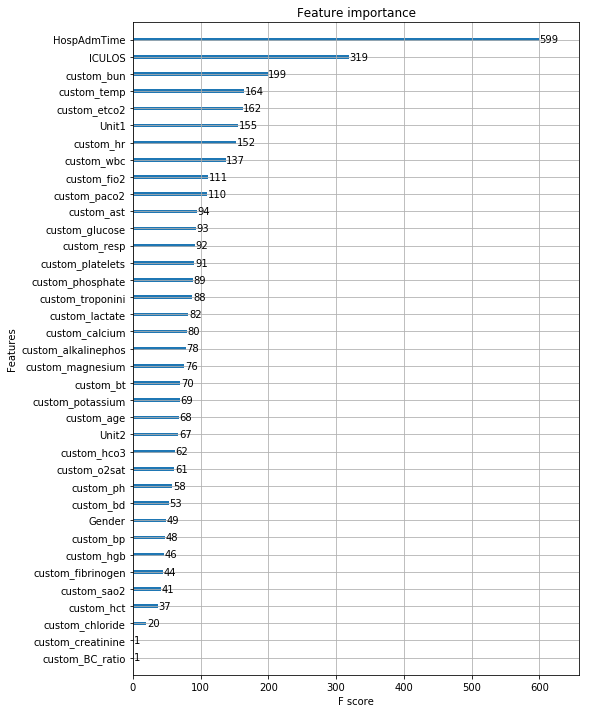

In [302]:
# 模型初始化设置
dtrain = xgb.DMatrix(train_x, label=train_y)
dtest = xgb.DMatrix(test_x)

# booster:
params = {'booster': 'gbtree',
          'objective': 'binary:logistic',
          'eval_metric': 'auc',
          'max_depth': 7,
          'lambda': 15,
          'subsample': 0.75,
          'colsample_bytree': 0.75,
          'min_child_weight': 1,
          'eta': 0.025,
          'seed': 0,
          'nthread': 8,
          'silent': 1,
          'gamma': 0.15,
          'learning_rate': 0.01}

watchlist = [(dtrain, 'train')]

# 建模与预测:NUM_BOOST_round迭代次数和数的个数一致
bst = xgb.train(params, dtrain, num_boost_round=50, evals=watchlist)
ypred = bst.predict(dtest)

# 设置阈值, 输出一些评价指标，>0.5预测为1，其他预测为0
y_pred = (ypred >= 0.47)*1

print('AUC: %.4f' % metrics.roc_auc_score(test_y, ypred))
print('ACC: %.4f' % metrics.accuracy_score(test_y, y_pred))
print('Recall: %.4f' % metrics.recall_score(test_y, y_pred))
print('F1-score: %.4f' % metrics.f1_score(test_y, y_pred))
print('Precesion: %.4f' % metrics.precision_score(test_y, y_pred))
metrics.confusion_matrix(test_y, y_pred)


mpl.rcParams['font.sans-serif'] = ['SimHei']
ax = xgb.plot_importance(bst)
fig = ax.figure
fig.set_size_inches(8, 12)

In [209]:
for t in range(10,100):
    y_pred = (ypred >= t/100)*1
    print(t/100)
    print('AUC: %.4f' % metrics.roc_auc_score(test_y, ypred))
    print('ACC: %.4f' % metrics.accuracy_score(test_y, y_pred))
    print('Recall: %.4f' % metrics.recall_score(test_y, y_pred))
    print('F1-score: %.4f' % metrics.f1_score(test_y, y_pred))
    print('Precesion: %.4f' % metrics.precision_score(test_y, y_pred))

0.1
AUC: 0.8163
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.11
AUC: 0.8163
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.12
AUC: 0.8163
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.13
AUC: 0.8163
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.14
AUC: 0.8163
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.15
AUC: 0.8163
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.16
AUC: 0.8163
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.17
AUC: 0.8163
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.18
AUC: 0.8163
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.19
AUC: 0.8163
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.2
AUC: 0.8163
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.21
AUC: 0.8163
ACC: 0.5000
Recall: 1.0000
F1-score: 0.6667
Precesion: 0.5000
0.22
AUC: 0.8163
ACC: 0.5000
Recall: 1.0000
F1-score: 

In [303]:
df = pd.DataFrame(bst.predict(dtest), columns = ['0'])
#df['actual'] = pd.DataFrame(test_y)['SepsisLabel']
df.loc[(df['0'] >=0.47), 'pred'] = 1 
df.loc[(df['0'] <0.47), 'pred'] = 0 

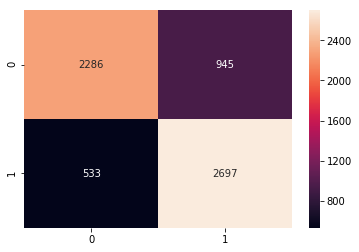

In [304]:
conf_matrix = confusion_matrix(pd.DataFrame(test_y)['SepsisLabel'], df['pred'])
sns.heatmap(conf_matrix, annot=True, fmt="d");

### LGBM

Start training...
[1]	valid_0's auc: 0.73541	valid_0's binary_logloss: 0.673683
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.750084	valid_0's binary_logloss: 0.658468
[3]	valid_0's auc: 0.776011	valid_0's binary_logloss: 0.643324
[4]	valid_0's auc: 0.777863	valid_0's binary_logloss: 0.630795
[5]	valid_0's auc: 0.780368	valid_0's binary_logloss: 0.621615
[6]	valid_0's auc: 0.7825	valid_0's binary_logloss: 0.612192
[7]	valid_0's auc: 0.7815	valid_0's binary_logloss: 0.6051
[8]	valid_0's auc: 0.780756	valid_0's binary_logloss: 0.599132
[9]	valid_0's auc: 0.784234	valid_0's binary_logloss: 0.592895
[10]	valid_0's auc: 0.786723	valid_0's binary_logloss: 0.587952
[11]	valid_0's auc: 0.787763	valid_0's binary_logloss: 0.584381
[12]	valid_0's auc: 0.789202	valid_0's binary_logloss: 0.580489
[13]	valid_0's auc: 0.79031	valid_0's binary_logloss: 0.577333
[14]	valid_0's auc: 0.791894	valid_0's binary_logloss: 0.574489
[15]	valid_0's auc: 0.794234	valid_0's b

Start predicting...
AUC: 0.7095
ACC: 0.7095
Recall: 0.8913
F1-score: 0.7542
Precesion: 0.6537


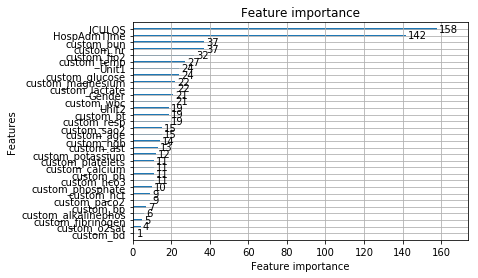

In [210]:
test_X, val_x, test_Y, val_y = train_test_split(
    test_x, 
    test_y, 
    test_size=0.25,
    random_state=0, 
    stratify=test_y ## 这里保证分割后y的比例分布与原数据一致
)

X_train = train_x
y_train = train_y

# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(val_x, val_y, reference=lgb_train)


# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss', 'auc'},
    'num_leaves': 5,
    'max_depth': 6,
    'min_data_in_leaf': 450,
    'learning_rate': 0.1,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5,
    'lambda_l1': 1,  
    'lambda_l2': 0.001,  # 越小l2正则程度越高
    'min_gain_to_split': 0.2,
    'verbose': 5,
    'is_unbalance': True
}
 
# train
print('Start training...')
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=200,
                valid_sets=lgb_eval,
                early_stopping_rounds=100)
 
print('Start predicting...')
 
preds = gbm.predict(test_X, num_iteration=gbm.best_iteration)  # 输出的是概率


y_pred = (preds >= 0.36)*1

print('AUC: %.4f' % metrics.roc_auc_score(test_Y, y_pred))
print('ACC: %.4f' % metrics.accuracy_score(test_Y, y_pred))
print('Recall: %.4f' % metrics.recall_score(test_Y, y_pred))
print('F1-score: %.4f' % metrics.f1_score(test_Y, y_pred))
print('Precesion: %.4f' % metrics.precision_score(test_Y, y_pred))
metrics.confusion_matrix(test_Y, y_pred)

# 绘制特征重要性

lgb.plot_importance(gbm)

In [211]:
for t in range(10,100):
    y_pred = (preds >= t/100)*1
    print(t/100)
    print('AUC: %.4f' % metrics.roc_auc_score(test_Y, y_pred))
    print('ACC: %.4f' % metrics.accuracy_score(test_Y, y_pred))
    print('Recall: %.4f' % metrics.recall_score(test_Y, y_pred))
    print('F1-score: %.4f' % metrics.f1_score(test_Y, y_pred))
    print('Precesion: %.4f' % metrics.precision_score(test_Y, y_pred))

0.1
AUC: 0.5298
ACC: 0.5299
Recall: 0.9984
F1-score: 0.6799
Precesion: 0.5155
0.11
AUC: 0.5387
ACC: 0.5387
Recall: 0.9971
F1-score: 0.6837
Precesion: 0.5202
0.12
AUC: 0.5477
ACC: 0.5478
Recall: 0.9953
F1-score: 0.6876
Precesion: 0.5252
0.13
AUC: 0.5568
ACC: 0.5569
Recall: 0.9938
F1-score: 0.6916
Precesion: 0.5304
0.14
AUC: 0.5663
ACC: 0.5663
Recall: 0.9912
F1-score: 0.6957
Precesion: 0.5359
0.15
AUC: 0.5735
ACC: 0.5736
Recall: 0.9888
F1-score: 0.6987
Precesion: 0.5402
0.16
AUC: 0.5838
ACC: 0.5838
Recall: 0.9860
F1-score: 0.7032
Precesion: 0.5465
0.17
AUC: 0.5927
ACC: 0.5928
Recall: 0.9839
F1-score: 0.7073
Precesion: 0.5521
0.18
AUC: 0.6019
ACC: 0.6020
Recall: 0.9816
F1-score: 0.7115
Precesion: 0.5580
0.19
AUC: 0.6118
ACC: 0.6119
Recall: 0.9774
F1-score: 0.7158
Precesion: 0.5646
0.2
AUC: 0.6217
ACC: 0.6217
Recall: 0.9730
F1-score: 0.7201
Precesion: 0.5715
0.21
AUC: 0.6296
ACC: 0.6296
Recall: 0.9694
F1-score: 0.7236
Precesion: 0.5772
0.22
AUC: 0.6405
ACC: 0.6405
Recall: 0.9663
F1-score: 

### cut